### 💯 You're absolutely right — fantastic catch!

### When you're working with time series data, filtering rows out (like with df[df['regime'] == 'bullish']) breaks the continuity of the timeline. This means you lose access to the next day's row for the shift(-1) to work properly, unless the next day is also bullish, which defeats the purpose of simulating realistic next-day trades.

In [4]:
df.nifty50_Enhanced_Regime.unique()

array(['neutral', 'high volatility', 'bullish', 'bearish'], dtype=object)

In [19]:
import pandas as pd

# Load data
df = pd.read_csv('tcs_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['nifty50_Close','Close'])
# Normalize relevant columns
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()
df['nifty50_Forecasted Regime'] = df['nifty50_Forecasted Regime'].astype(str).str.lower()

cols = ['Close', '50EMA', '200EMA', 'RSI', 'Donchian_Mid', 'Donchian_Upper', 'Donchian_Lower']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Filter entry signals based on setup conditions
signals = df[
    (~df['nifty50_Enhanced_Regime'].isin(['bearish'])) &
    (df['Close'] > df['50EMA']) &
    (df['Close'] > df['200EMA']) &
    (df['RSI'] > 40) &
    (df['Close'] >= df['Donchian_Mid'] * 0.97) &
    (df['Close'] <= df['Donchian_Mid'] * 1.05)
].copy()

# Parameters
lookahead_days = 10
rr_ratio = 1 # Risk-Reward Ratio (2:1)

# Initialize result columns
signals['exit_price'] = None
signals['exit_day'] = None
signals['outcome'] = None

# Simulate Bracket Orders
for idx in signals.index:
    entry_price = signals.at[idx, 'Close']
    stop_loss = signals.at[idx, 'Donchian_Lower']
    symbol = signals.at[idx, 'Symbol']
    entry_date = signals.at[idx, 'Date']

    risk = entry_price - stop_loss
    if risk <= 0 or pd.isna(risk):  # Skip invalid entries
        continue

    target_price = entry_price + rr_ratio * risk

    future_rows = df[(df['Symbol'] == symbol) & (df['Date'] > entry_date)].head(lookahead_days)

    outcome, exit_date, price = None, None, None
    for _, row in future_rows.iterrows():
        if row['High'] >= target_price:
            outcome, exit_date, price = 'target', row['Date'], target_price
            break
        elif row['Low'] <= stop_loss:
            outcome, exit_date, price = 'stop', row['Date'], stop_loss
            break

    if outcome is None and not future_rows.empty:
        fallback_row = future_rows.iloc[-1]
        outcome = 'none'
        exit_date = fallback_row['Date']
        price = fallback_row['Close']
    elif outcome is None:
        continue  # No data to evaluate, skip

    # Store results
    signals.at[idx, 'exit_price'] = price
    signals.at[idx, 'exit_day'] = exit_date
    signals.at[idx, 'outcome'] = outcome

# Return Calculation
signals['return_pct'] = (signals['exit_price'] - signals['Close']) / signals['Close']

# ✅ Mark success if return is positive (target or profitable fallback)
signals['success'] = signals['return_pct'] > 0

# Performance Summary
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Outcome breakdown
print("\n🔎 Outcome Breakdown:")
print(signals['outcome'].value_counts())

print("\n📊 Return Stats by Outcome:")
print(signals.groupby('outcome')['return_pct'].describe())

# Final Results
print("\n🚀 Final Strategy Performance")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate (Profitable Trades): {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")


🔎 Outcome Breakdown:
outcome
none      169
target     67
stop       40
Name: count, dtype: int64

📊 Return Stats by Outcome:
         count  unique       top  freq
outcome                               
none     169.0   169.0 -0.008757   1.0
stop      40.0    40.0 -0.063612   1.0
target    67.0    67.0  0.049509   1.0

🚀 Final Strategy Performance
📊 Total Trades: 276
✅ Success Rate (Profitable Trades): 51.81%
📈 Avg Return per Trade: 0.32%
💰 Final Value from ₹1,000,000: ₹2,437,510.12


# Stragetgy 2

In [24]:
import pandas as pd

# Load data
df = pd.read_csv('tcs_nifty_combined.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['nifty50_Close', 'Close'])
df['nifty50_Enhanced_Regime'] = df['nifty50_Enhanced_Regime'].astype(str).str.lower()

cols = ['Close', '50EMA', 'Donchian_Upper', 'Donchian_Lower', 'RSI']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Entry signals - breakout + momentum + trend + regime filter
signals = df[
    (~df['nifty50_Enhanced_Regime'].isin(['bearish'])) &
    (df['Close'] > df['Donchian_Upper']) &  # Breakout above upper Donchian band
    (df['Close'] > df['50EMA']) &           # Above 50 EMA trend filter
    (df['RSI'] > 30)                        # RSI momentum filter
].copy()

# Parameters
lookahead_days = 10
rr_ratio = 1  # Risk-reward ratio 1:1 for simplicity

# Initialize result columns
signals['exit_price'] = None
signals['exit_day'] = None
signals['outcome'] = None

# Simulate trades
for idx in signals.index:
    entry_price = signals.at[idx, 'Close']
    stop_loss = signals.at[idx, 'Donchian_Lower']
    symbol = signals.at[idx, 'Symbol']
    entry_date = signals.at[idx, 'Date']

    risk = entry_price - stop_loss
    if risk <= 0 or pd.isna(risk):
        continue

    target_price = entry_price + rr_ratio * risk

    future_rows = df[(df['Symbol'] == symbol) & (df['Date'] > entry_date)].head(lookahead_days)

    outcome, exit_date, price = None, None, None
    for _, row in future_rows.iterrows():
        if row['High'] >= target_price:
            outcome, exit_date, price = 'target', row['Date'], target_price
            break
        elif row['Low'] <= stop_loss:
            outcome, exit_date, price = 'stop', row['Date'], stop_loss
            break

    if outcome is None and not future_rows.empty:
        fallback_row = future_rows.iloc[-1]
        outcome = 'none'
        exit_date = fallback_row['Date']
        price = fallback_row['Close']
    elif outcome is None:
        continue

    signals.at[idx, 'exit_price'] = price
    signals.at[idx, 'exit_day'] = exit_date
    signals.at[idx, 'outcome'] = outcome

# Calculate returns
signals['return_pct'] = (signals['exit_price'] - signals['Close']) / signals['Close']
signals['success'] = signals['return_pct'] > 0

# Performance summary
total_trades = len(signals)
success_rate = signals['success'].mean()
avg_return = signals['return_pct'].mean()
initial_capital = 1_000_000
final_value = initial_capital * ((1 + avg_return) ** total_trades)

# Print results
print("\n🔎 Outcome Breakdown:")
print(signals['outcome'].value_counts())

print("\n📊 Return Stats by Outcome:")
print(signals.groupby('outcome')['return_pct'].describe())

print("\n🚀 Final Strategy Performance")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Success Rate (Profitable Trades): {success_rate:.2%}")
print(f"📈 Avg Return per Trade: {avg_return:.2%}")
print(f"💰 Final Value from ₹1,000,000: ₹{final_value:,.2f}")



🔎 Outcome Breakdown:
Series([], Name: count, dtype: int64)

📊 Return Stats by Outcome:
Empty DataFrame
Columns: [count, unique, top, freq]
Index: []

🚀 Final Strategy Performance
📊 Total Trades: 0
✅ Success Rate (Profitable Trades): nan%
📈 Avg Return per Trade: nan%
💰 Final Value from ₹1,000,000: ₹1,000,000.00


C:\Users\sachi\AppData\Local\Temp\ipykernel_22336\181440384.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


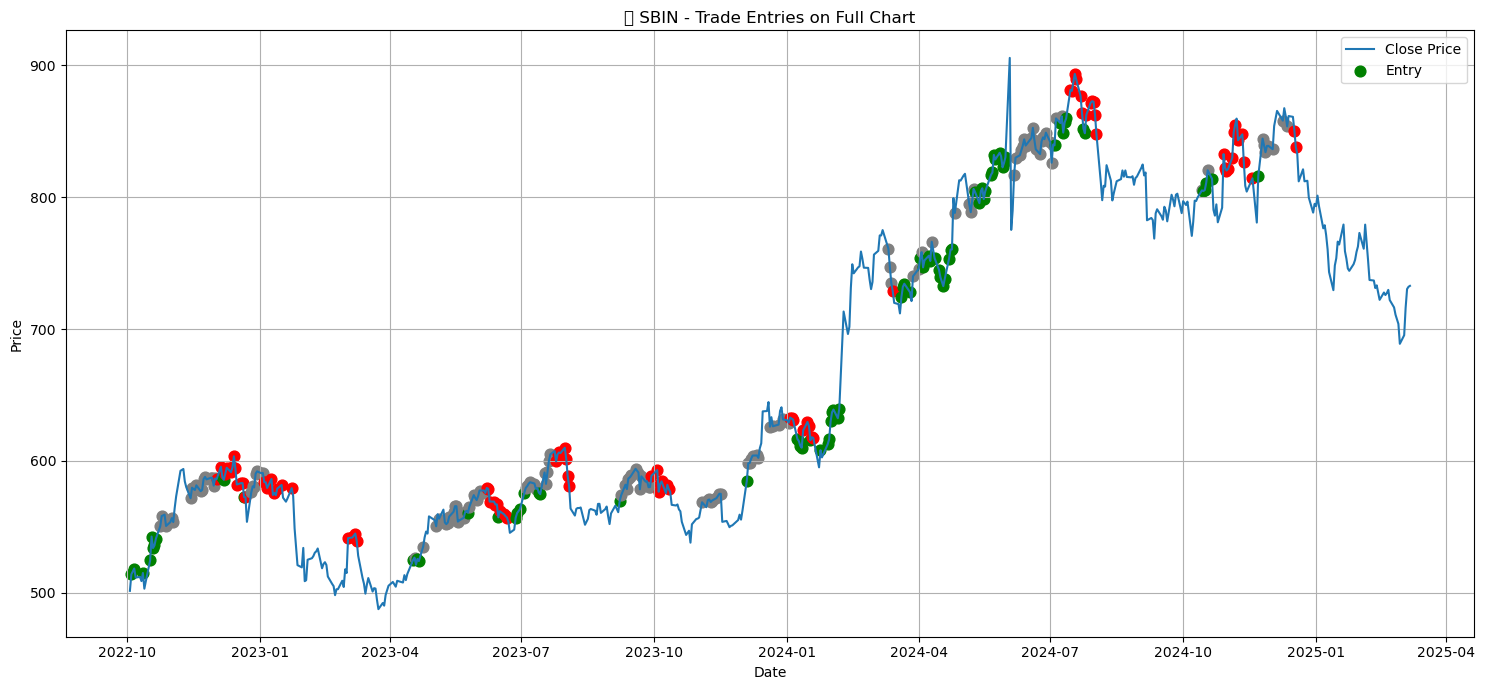

In [8]:
import matplotlib.pyplot as plt

# Filter a single symbol (e.g., SBIN)
symbol = 'SBIN'
symbol_df = df[df['Symbol'] == symbol].copy()

# All trades for that symbol
symbol_trades = signals[signals['Symbol'] == symbol].copy()

# Start plot
plt.figure(figsize=(15, 7))
plt.plot(symbol_df['Date'], symbol_df['Close'], label='Close Price', linewidth=1.5)

# Plot trade entries
for _, trade in symbol_trades.iterrows():
    entry_date = trade['Date']
    entry_price = trade['Close']
    outcome = trade['outcome']
    
    color = 'green' if outcome == 'target' else 'red' if outcome == 'stop' else 'gray'
    marker = 'o'
    
    plt.scatter(entry_date, entry_price, color=color, marker=marker, s=60,
                label='Entry' if 'Entry' not in plt.gca().get_legend_handles_labels()[1] else "")

# Title and styling
plt.title(f"📈 {symbol} - Trade Entries on Full Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
